In [1]:
import torch
from torch import nn,Tensor
from torch.utils.data import DataLoader

torch.set_printoptions(threshold=10_000)

import math
from time import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEVICE)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 3070


In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U torchdata
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [4]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
        
        pe = torch.zeros(max_len, embedding_dim)
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(-2) ###
        
        self.register_buffer("pos_embedding", pe)
        
        
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pos_embedding[:x.size(0),:]
        return self.dropout(x)
    
    
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedded_dim):
        super(TokenEmbedding, self).__init__()
        
        self.embedded_dim = embedded_dim
        self.embedding = nn.Embedding(vocab_size, embedded_dim)
        
    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.embedded_dim)
        
        return x

In [5]:
class seq2seqTransformer(nn.Module):
    def __init__(self, embedded_dim: int, n_heads: int, num_encoder_layers: int, num_decoder_layers: int, 
                 dim_feedforward: int, src_vocab_size: int, tgt_vocab_size: int, dropout: float = 0.1):
        super(seq2seqTransformer, self).__init__()
        
        ## Word Embedding
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embedded_dim)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedded_dim)
        ## Positional Encoding
        self.positional_encoding = PositionalEncoding(embedded_dim, dropout)
        ## Transformer Block
        self.transformer = nn.Transformer(d_model = embedded_dim, nhead = n_heads, num_encoder_layers = num_encoder_layers, 
                                          num_decoder_layers = num_decoder_layers,  dim_feedforward = dim_feedforward, 
                                          dropout = dropout)
        ## Fully connected layer
        self.generator = nn.Linear(embedded_dim, tgt_vocab_size)

        
    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor, tgt_mask: Tensor, src_padding_mask: Tensor, 
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        ## Source embedding + positional encoding
        src_emb = self.src_tok_emb(src)
        src_emd = self.positional_encoding(src_emb)
        ## Target embedding + positional encoding
        trg_emb = self.tgt_tok_emb(trg)
        trg_emb = self.positional_encoding(trg_emb)
        ## Transformer Block
        out = self.transformer(src_emd, trg_emb, src_mask, tgt_mask, None, # memory_mask
                               src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        ## Fully connected layer
        out = self.generator(out)
        
        return out
     
    def encode(self, src: Tensor, src_mask: Tensor):
        x = self.src_tok_emb(src)
        x = self.positional_encoding(x)
        out = self.transformer.encoder(x, src_mask)
        
        return out
    
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        x = self.tgt_tok_emb(tgt)
        x = self.positional_encoding(x)
        out = self.transformer.decoder(x, memory, tgt_mask)
        
        return out    
    

In [6]:
def generate_square_subsequent_mask(sz: int, device=DEVICE) -> Tensor:
    """Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
    """
    return torch.triu(torch.full((sz, sz), float('-inf'), device=device), diagonal=1)

def create_mask(src, tgt, device=DEVICE):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
 
    src_mask = torch.zeros((src_seq_len,src_seq_len), device=device).type(torch.bool)
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

generate_square_subsequent_mask(5)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [7]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.1


transformer = seq2seqTransformer(embedded_dim=EMB_SIZE, n_heads=NHEAD, num_encoder_layers=NUM_ENCODER_LAYERS,
                                num_decoder_layers=NUM_DECODER_LAYERS, dim_feedforward=FFN_HID_DIM,
                                src_vocab_size=SRC_VOCAB_SIZE, tgt_vocab_size=TGT_VOCAB_SIZE, dropout=DROPOUT)

# Initialize parameters with Glorot / fan_avg.
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [8]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [9]:
def train_epoch(model, optimizer, criterion):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(dataset=train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        tgt_input = tgt[:-1, :] ## no need for the last EOS
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src=src, tgt=tgt_input, device=DEVICE)
        outputs = model(src=src, trg=tgt_input, src_mask=src_mask, tgt_mask=tgt_mask, src_padding_mask=src_padding_mask, 
                tgt_padding_mask=tgt_padding_mask, memory_key_padding_mask=src_padding_mask)

        # backward
        tgt_out = tgt[1:, :] ## no need for BOS
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        # optimize
        optimizer.step()
        
        losses += loss.item()
        
    return losses / len(list(train_dataloader) * BATCH_SIZE)
    

def evaluate(model, criterion):
    model.eval()
    losses = 0
    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(dataset=val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in val_dataloader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        
        # forward 
        tgt_input = tgt[:-1, :] ## no need for the last EOS
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src=src, tgt=tgt_input, device=DEVICE)
        outputs = model(src=src, trg=tgt_input, src_mask=src_mask, tgt_mask=tgt_mask, src_padding_mask=src_padding_mask, 
                tgt_padding_mask=tgt_padding_mask, memory_key_padding_mask=src_padding_mask)
        
        tgt_out = tgt[1:, :] ## no need for BOS
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), tgt_out.reshape(-1))      
        losses += loss.item()
        
    return losses / len(list(val_dataloader) * BATCH_SIZE)


def plot_losses(losses_train, losses_val, title = ""):
    '''
    Plots the losses per epoch returned by the training function.
    Args:
        losses: a list of losses returned by train
        title: a title for the graph
    '''
    epochs = [i for i in range(1, len(losses_train) + 1)]
    plt.plot(epochs, losses_train, marker=".", linestyle="dashed", label = "train")
    plt.plot(epochs, losses_val, marker=".", linestyle="dashed", label = "validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title)
    plt.show()
    

Epoch: 1, Train loss: 0.0411, Val loss: 0.0313, Epoch time = 22.478 sec
Epoch: 2, Train loss: 0.0290, Val loss: 0.0258, Epoch time = 21.903 sec
Epoch: 3, Train loss: 0.0245, Val loss: 0.0227, Epoch time = 21.860 sec
Epoch: 4, Train loss: 0.0215, Val loss: 0.0205, Epoch time = 21.916 sec
Epoch: 5, Train loss: 0.0193, Val loss: 0.0192, Epoch time = 21.877 sec
Epoch: 6, Train loss: 0.0175, Val loss: 0.0179, Epoch time = 21.860 sec
Epoch: 7, Train loss: 0.0160, Val loss: 0.0172, Epoch time = 21.887 sec
Epoch: 8, Train loss: 0.0148, Val loss: 0.0166, Epoch time = 21.903 sec
Epoch: 9, Train loss: 0.0137, Val loss: 0.0161, Epoch time = 21.959 sec
Epoch: 10, Train loss: 0.0127, Val loss: 0.0157, Epoch time = 21.874 sec
Epoch: 11, Train loss: 0.0119, Val loss: 0.0155, Epoch time = 21.903 sec
Epoch: 12, Train loss: 0.0111, Val loss: 0.0154, Epoch time = 21.909 sec
Epoch: 13, Train loss: 0.0104, Val loss: 0.0153, Epoch time = 21.908 sec
Epoch: 14, Train loss: 0.0098, Val loss: 0.0152, Epoch time 

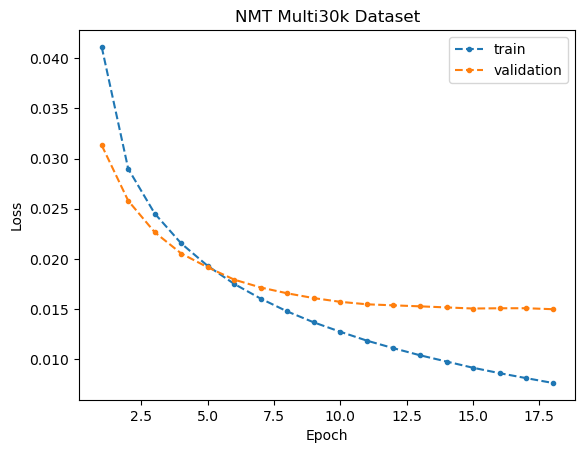

In [10]:
NUM_EPOCHS = 18
losses_train = []
losses_val = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time()
    train_loss = train_epoch(transformer, optimizer, loss_fn)
    end_time = time()
    val_loss = evaluate(transformer, loss_fn)
    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f},"
           f" Epoch time = {(end_time - start_time):.3f} sec"))
    losses_train.append(train_loss)
    losses_val.append(val_loss)

plot_losses(losses_train, losses_val,  title="NMT Multi30k Dataset")

In [11]:
# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src, src_mask = src.to(DEVICE), src_mask.to(DEVICE)
    
    memory = model.encode(src, src_mask)
    memory = memory.to(DEVICE)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(0), device=DEVICE)).type(torch.bool)
        
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys, torch.ones(1,1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    
    return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [12]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people stand in front of an igloo . 


In [13]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Park ."))

 A group of people stand in front of a park . 


In [14]:
print(translate(transformer, "Ich bin in den Zoo gegangen ."))

 I I am in the zoo . 
